<a href="https://colab.research.google.com/github/karthik19-cloud/GenAI-Training/blob/main/draw_neural_network-output.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
# 1) Imports
import os
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [11]:
# 2) Load the CSV
# --- Option A: If your file is in /content/sample_data/pima_diabetes.csv
CSV_PATH = "/content/sample_data/pima-indians-diabetes.csv"

# --- Option B: Upload interactively instead (uncomment to use)
# from google.colab import files
# uploaded = files.upload()
# CSV_PATH = list(uploaded.keys())[0]

if not os.path.exists(CSV_PATH):
    raise FileNotFoundError(
        f"CSV not found at {CSV_PATH}. "
        "Place your file there or use the upload snippet above."
    )

df = pd.read_csv(CSV_PATH)
print("✅ Loaded shape:", df.shape)
print(df.head())

✅ Loaded shape: (768, 9)
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  


In [12]:
# 3) Ensure expected columns (rename if needed)
expected_cols = [
    "Pregnancies","Glucose","BloodPressure","SkinThickness","Insulin",
    "BMI","DiabetesPedigreeFunction","Age","Outcome"
]
# Try to align columns if user had slightly different casing/spacing
df.columns = [c.strip() for c in df.columns]
missing = [c for c in expected_cols if c not in df.columns]
if missing:
    raise ValueError(f"Missing expected columns: {missing}\nFound: {list(df.columns)}")


In [13]:
# 4) Basic cleaning:
# These features sometimes contain zeros that mean "missing".
zero_as_missing = ["Glucose","BloodPressure","SkinThickness","Insulin","BMI"]
for col in zero_as_missing:
    df[col] = df[col].replace(0, np.nan)

# Separate X/y
X = df[expected_cols[:-1]].copy()
y = df["Outcome"].values

# 5) Train/Val split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 6) Preprocess pipeline: impute + scale
numeric_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
X_train_proc = numeric_pipeline.fit_transform(X_train)
X_val_proc   = numeric_pipeline.transform(X_val)


In [14]:
# 7) Build a simple feedforward NN
tf.random.set_seed(42)

model = keras.Sequential([
    layers.Input(shape=(X_train_proc.shape[1],), name="input"),
    layers.Dense(16, activation="relu", name="dense_1"),
    layers.Dropout(0.2, name="dropout_1"),
    layers.Dense(8, activation="relu", name="dense_2"),
    layers.Dense(1, activation="sigmoid", name="output")
], name="pima_diabetes_nn")

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy", keras.metrics.AUC(name="auc")]
)

model.summary()


Model: "pima_diabetes_nn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 289 (1.13 KB)

 Trainable params: 289 (1.13 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# 8) Train
history = model.fit(
    X_train_proc, y_train,
    validation_data=(X_val_proc, y_val),
    epochs=50,
    batch_size=32,
    verbose=0
)

print(f"✅ Val Accuracy: {model.evaluate(X_val_proc, y_val, verbose=0)[1]:.3f}, "
      f"Val AUC: {model.evaluate(X_val_proc, y_val, verbose=0)[2]:.3f}")


✅ Val Accuracy: 0.727, Val AUC: 0.806


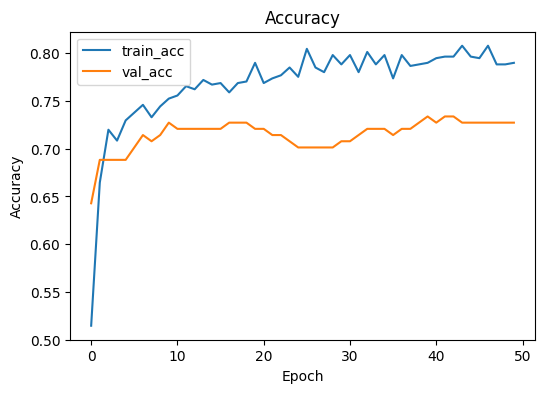

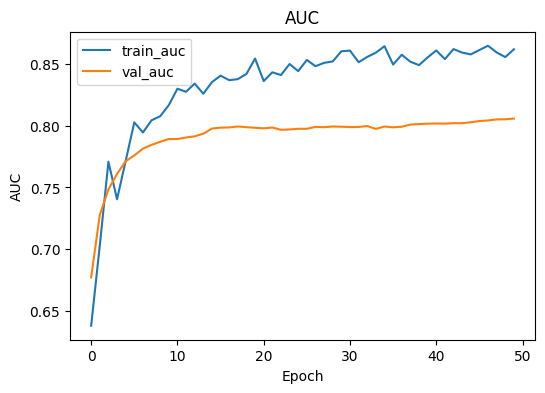

In [16]:
# 9) Plot training curves
plt.figure(figsize=(6,4))
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("Accuracy")
plt.legend(); plt.show()

plt.figure(figsize=(6,4))
plt.plot(history.history["auc"], label="train_auc")
plt.plot(history.history["val_auc"], label="val_auc")
plt.xlabel("Epoch"); plt.ylabel("AUC"); plt.title("AUC")
plt.legend(); plt.show()

🖼️ Model diagram saved at: /content/pima_nn_architecture.png


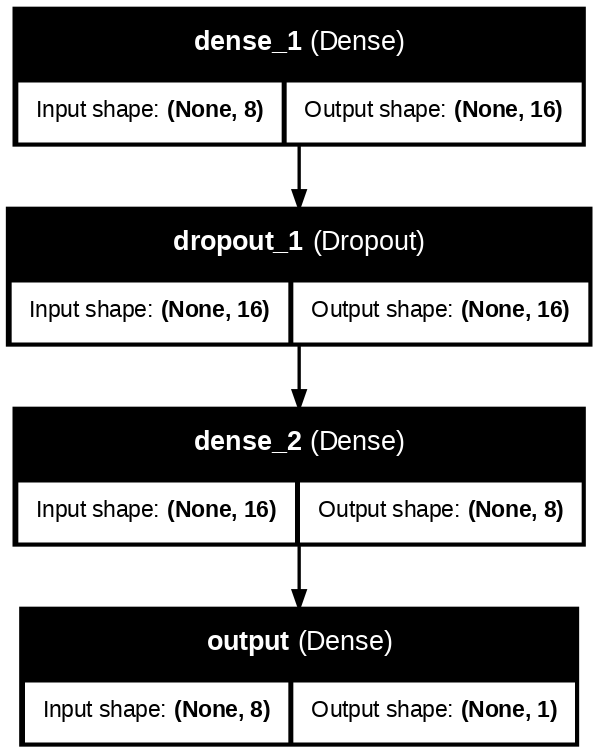

In [17]:
# 10) DRAW THE NETWORK (Graphviz)
from tensorflow.keras.utils import plot_model

try:
    diagram_path = "/content/pima_nn_architecture.png"
    plot_model(
        model,
        to_file=diagram_path,
        show_shapes=True,
        show_layer_names=True,
        dpi=120,
        expand_nested=True
    )
    from IPython.display import Image, display
    print("🖼️ Model diagram saved at:", diagram_path)
    display(Image(filename=diagram_path))
except Exception as e:
    print("⚠️ Graphviz/pydot diagram failed:", e)
    print("Falling back to a simple Matplotlib schematic...")

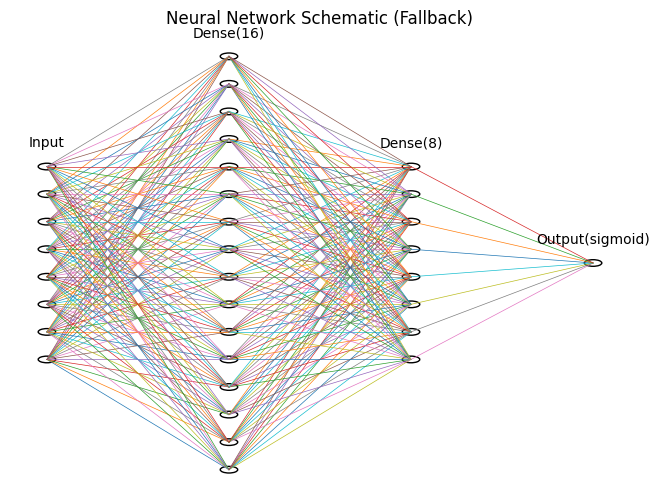

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
🔮 Example prediction: P(diabetes)=0.639 → class=1


In [19]:
# 11) Fallback: draw a simple schematic with Matplotlib
# Layer sizes
layer_sizes = [X_train_proc.shape[1], 16, 8, 1]
layer_names = ["Input", "Dense(16)", "Dense(8)", "Output(sigmoid)"]

# Layout
v_spacing = 1.0
h_spacing = 2.5
fig, ax = plt.subplots(figsize=(8, 6))
ax.axis('off')

# Node positions
positions = []
for li, size in enumerate(layer_sizes):
    xs = li * h_spacing
    ys = np.linspace(- (size-1)/2, (size-1)/2, size) * v_spacing
    positions.append([(xs, y) for y in ys])

# Draw connections
for li in range(len(layer_sizes) - 1):
    for (x1, y1) in positions[li]:
        for (x2, y2) in positions[li+1]:
            ax.plot([x1, x2], [y1, y2], linewidth=0.5)

# Draw nodes
for li, layer in enumerate(positions):
    for (x, y) in layer:
        circle = plt.Circle((x, y), 0.12, fill=False)
        ax.add_patch(circle)
    # Layer label
    ax.text(layer[0][0], max(p[1] for p in layer) + 0.6, layer_names[li],
            ha='center', va='bottom', fontsize=10)

plt.title("Neural Network Schematic (Fallback)")
plt.show()

# 12) Example: predict a single sample
sample = np.array([[6, 148, 72, 35, 0, 33.6, 0.627, 50]])  # example row format
sample_proc = numeric_pipeline.transform(pd.DataFrame(sample, columns=X.columns))
proba = model.predict(sample_proc)[0,0]
pred  = int(proba >= 0.5)
print(f"🔮 Example prediction: P(diabetes)={proba:.3f} → class={pred}")